<>:161: SyntaxWarning: invalid escape sequence '\H'
<>:161: SyntaxWarning: invalid escape sequence '\H'
/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_28725/4261295489.py:161: SyntaxWarning: invalid escape sequence '\H'
  print("\Highest OOB Parameter Grid:")


test shape =  (62, 13)
train shape =  (234, 13)
test shape =  (62, 13)
train shape =  (234, 13)
---------- Select predictors for training set ----------
X shape:  (234, 10)
X data: 
           HDL       LDL        age  sex  randomized_group  race   insulin  \
0   -1.013848  0.159223  55.245374    0                 0     5  0.217275   
1    0.074411 -0.009366  39.362775    0                 1     5 -0.004744   
2   -1.195225 -0.290347  29.654385    0                 0     5 -0.226763   
3    0.799917 -0.964702  53.022307    0                 1     2  0.661313   
4    0.074411  0.664989  28.712545    0                 0     7 -0.004744   
..        ...       ...        ...  ...               ...   ...       ...   
229  1.525423  0.833577  52.696382    1                 1     2 -0.670801   
230 -0.469719  1.114559  28.728744    1                 1     5 -0.004744   
231 -0.469719  1.002166  55.825810    0                 1     5  0.217275   
232  0.074411 -0.009366  47.138545    0        

INFO     [merf.py:307] Training GLL is 955.4399533455879 at iteration 1.
INFO     [merf.py:307] Training GLL is 954.054366633126 at iteration 2.
INFO     [merf.py:307] Training GLL is 943.9747303043237 at iteration 3.
INFO     [merf.py:307] Training GLL is 935.7780333685342 at iteration 4.
INFO     [merf.py:307] Training GLL is 930.5034129160214 at iteration 5.
INFO     [merf.py:307] Training GLL is 921.3159375883167 at iteration 6.
INFO     [merf.py:307] Training GLL is 916.7891089441665 at iteration 7.
INFO     [merf.py:307] Training GLL is 913.9374915363993 at iteration 8.
INFO     [merf.py:307] Training GLL is 910.897336052041 at iteration 9.
INFO     [merf.py:307] Training GLL is 906.0669308891573 at iteration 10.
INFO     [merf.py:307] Training GLL is 1025.7849645519445 at iteration 1.
INFO     [merf.py:307] Training GLL is 1009.8153813359145 at iteration 2.
INFO     [merf.py:307] Training GLL is 1005.073737520056 at iteration 3.
INFO     [merf.py:307] Training GLL is 997.4013181

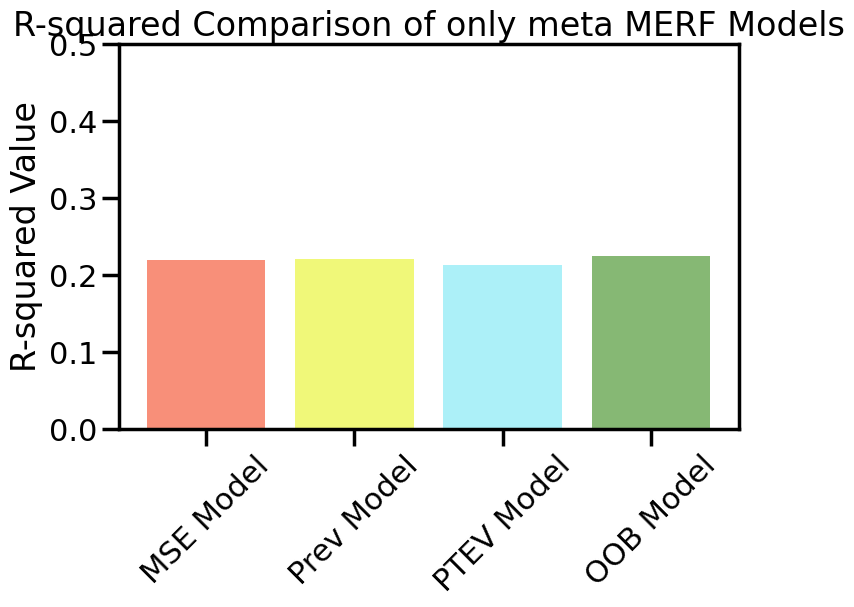

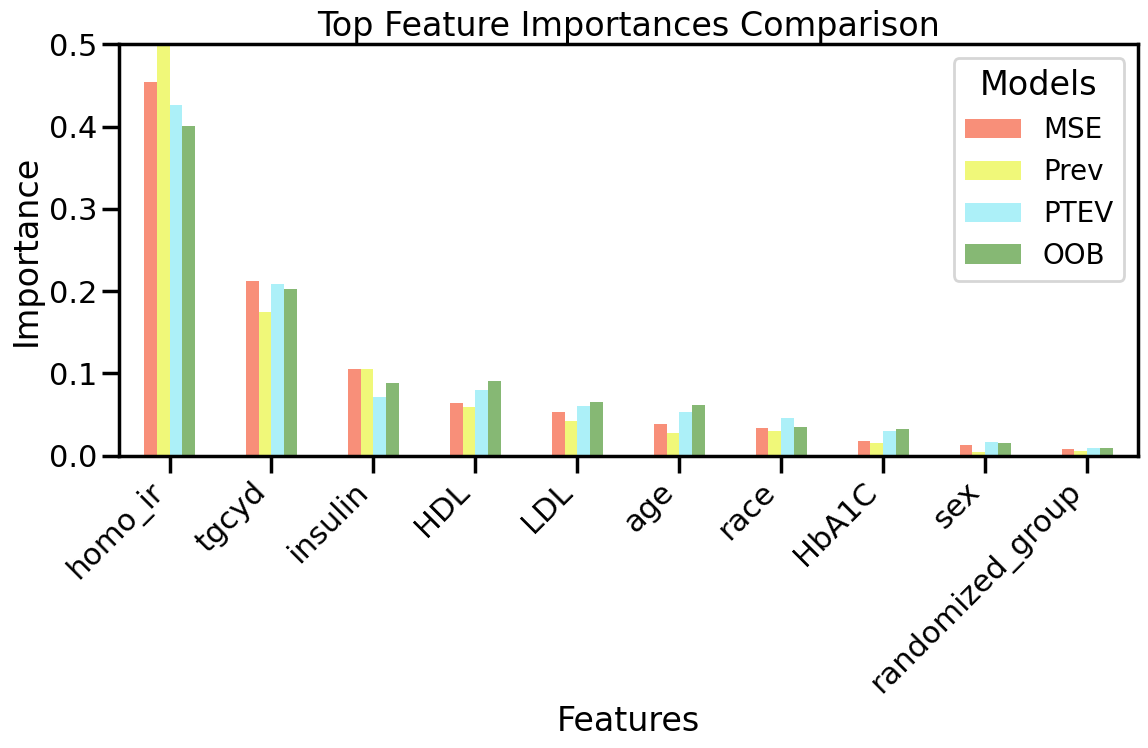

In [4]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib as mpl
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
sns.set_context("poster")
mpl.rcParams['figure.figsize'] = (11,8)

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

### OUTPUT NAME CHANGES ###
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/1.clinical/deltas"
#r2_out = 'r_squared_meta_merf_models.png'
#feature_imp_out = 'top_feature_importances_meta.png'
r2_out = 'r_squared_meta_merf_models_weight.png'
feature_imp_out = 'top_feature_importances_meta_weight.png'
os.makedirs(output_dir, exist_ok=True)

### ### ### ### ### ### ###
m1_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical"
test = read_data(m1_dir, "jan30_all_delta_test_imp_varcheck.csv")
train = read_data(m1_dir, "jan30_all_delta_train_imp_varcheck.csv")

#columns_to_keep = ['subject_id', 'range', 'BMI', 'HDL', 'LDL', 'age', 'sex', 'randomized_group', 'race', 'insulin', 'homo_ir', 'tgcyd', 'HbA1C']
columns_to_keep = ['subject_id', 'range', 'Weight', 'HDL', 'LDL', 'age', 'sex', 'randomized_group', 'race', 'insulin', 'homo_ir', 'tgcyd', 'HbA1C']
train = train[columns_to_keep]
test = test[columns_to_keep]
df = pd.read_csv(os.path.join(df_dir,'dec5_maggie_params_tuning_raw_clinical_oob.csv'))

print("test shape = ", test.shape)
print("train shape = ", train.shape)

test = test.dropna()
train = train.dropna()

print("test shape = ", test.shape)
print("train shape = ", train.shape)

print("---------- Select predictors for training set ----------")
train_set = train
X = train_set.drop(['Weight', 'subject_id', 'range'], axis=1)
Y = train_set[['Weight']]
Y = Y['Weight'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['subject_id'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

print("X shape: ", X.shape)
print("X data: \n", X)

print("---------- Select predictors for test set ----------")
test_set = test
X_new = test_set.drop(['Weight', 'subject_id', 'range'], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match

Y_new = test_set['Weight'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['subject_id'])  # Convert to pandas Series
Z_new = np.ones((len(X_new), 1))

print("X_new shape: ", X_new.shape)
print("X_new data: \n", X_new)

# the line below filters out certain folds
# df = df[df['n_splits'] == 5]

# Find the row with the lowest mean_mse_score
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
print("First 5 columns for the lowest mean_mse_score:")
print(lowest_mse_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
print("First 5 columns for the lowest mean_prev_score:")
print(lowest_prev_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
print("First 5 columns for the lowest mean_ptev_score:")
print(lowest_ptev_row.iloc[:5])

# Find the row with the highest oob_score
highest_oob_row = df.loc[df['oob_score'].idxmax()]
print("\nFirst 5 columns for the highest oob_score:")
print(highest_oob_row.iloc[:5])

# Extract the rows for the parameter grids
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
highest_oob_row = df.loc[df['oob_score'].idxmax()]

# Create parameter grids from the extracted rows
best_mse_param_grid = {
    'n_estimators': [int(lowest_mse_row['n_estimators'])],
    #'max_depth': [int(lowest_mse_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_mse_row['max_depth']) else int(lowest_mse_row['max_depth'])],
    'min_samples_split': [float(lowest_mse_row['min_samples_split'])],
    #'min_samples_split': [float(lowest_mse_row['min_samples_split']) if lowest_mse_row['min_samples_split'] != 0 else 0.0],  # Convert 0 to 0.0
    'max_iter': [int(lowest_mse_row['max_iter'])],
    'n_splits': [int(lowest_mse_row['n_splits'])]
}
print("Best MSE Parameter Grid:")
print("n_estimators:", best_mse_param_grid['n_estimators'][0])
print("max_depth:", best_mse_param_grid['max_depth'][0])
print("min_samples_split:", best_mse_param_grid['min_samples_split'][0])
print("max_iter:", best_mse_param_grid['max_iter'][0])
print("n_splits:", best_mse_param_grid['n_splits'][0])

lowest_prev_param_grid = {
    'n_estimators': [int(lowest_prev_row['n_estimators'])],
    #'max_depth': [int(lowest_prev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_prev_row['max_depth']) else int(lowest_prev_row['max_depth'])],
    'min_samples_split': [float(lowest_prev_row['min_samples_split'])],
    'max_iter': [int(lowest_prev_row['max_iter'])],
    'n_splits': [int(lowest_prev_row['n_splits'])]
}
print("\nLowest Prev Parameter Grid:")
print("n_estimators:", lowest_prev_param_grid['n_estimators'][0])
print("max_depth:", lowest_prev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_prev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_prev_param_grid['max_iter'][0])
print("n_splits:", lowest_prev_param_grid['n_splits'][0])

lowest_ptev_param_grid = {
    'n_estimators': [int(lowest_ptev_row['n_estimators'])],
    #'max_depth': [int(lowest_ptev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_ptev_row['max_depth']) else int(lowest_ptev_row['max_depth'])],
    'min_samples_split': [float(lowest_ptev_row['min_samples_split'])],
    'max_iter': [int(lowest_ptev_row['max_iter'])],
    'n_splits': [int(lowest_ptev_row['n_splits'])]
}
print("\nLowest PTEV Parameter Grid:")
print("n_estimators:", lowest_ptev_param_grid['n_estimators'][0])
print("max_depth:", lowest_ptev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_ptev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_ptev_param_grid['max_iter'][0])
print("n_splits:", lowest_ptev_param_grid['n_splits'][0])

highest_oob_param_grid = {
    'n_estimators': [int(highest_oob_row['n_estimators'])],
    'max_depth': [None if pd.isna(highest_oob_row['max_depth']) else int(highest_oob_row['max_depth'])],
    'min_samples_split': [float(highest_oob_row['min_samples_split'])],
    'max_iter': [int(highest_oob_row['max_iter'])],
    'n_splits': [int(highest_oob_row['n_splits'])]
}
print("\Highest OOB Parameter Grid:")
print("n_estimators:", highest_oob_row['n_estimators'])
print("max_depth:", highest_oob_row['max_depth'])
print("min_samples_split:", highest_oob_row['min_samples_split'])
print("max_iter:", highest_oob_row['max_iter'])
print("n_splits:", highest_oob_row['n_splits'])


# Create MERF models for each parameter grid
mse_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_prev_param_grid['n_estimators'][0], 
                                max_depth = lowest_prev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_ptev_param_grid['n_estimators'][0], 
                                max_depth = lowest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_ptev_param_grid['max_iter'][0])

oob_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_oob_param_grid['n_estimators'][0], 
                                max_depth = highest_oob_param_grid['max_depth'][0], 
                                min_samples_split = highest_oob_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_oob_param_grid['max_iter'][0])


print("---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------")
mrf_mse = mse_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_oob = oob_merf.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

# Predict using the fitted model
clusters_new = pd.Series(test_set['subject_id'])
X_new = test_set.drop(['Weight', 'subject_id', 'range'], axis=1)
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
forest_mse = mrf_mse.trained_fe_model
oob_score_mse = round(forest_mse.oob_score_*100, 1)

y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
forest_prev = mrf_prev.trained_fe_model
oob_score_prev = round(forest_prev.oob_score_*100, 1)

y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
forest_ptev = mrf_ptev.trained_fe_model
oob_score_ptev = round(forest_ptev.oob_score_*100, 1)

y_hat_new_oob = mrf_oob.predict(X_new, Z_new, clusters_new)
forest_oob = mrf_oob.trained_fe_model
oob_score_tuned = round(forest_oob.oob_score_*100, 1)

### Calculate R-squared values for each model
color_palette = ['#F88F79', '#F0F879', '#ACF0F8', '#86B874']
r2_mse = r2_score(Y_new, y_hat_new_mse)
r2_prev = r2_score(Y_new, y_hat_new_prev)
r2_ptev = r2_score(Y_new, y_hat_new_ptev)
r2_oob = r2_score(Y_new, y_hat_new_oob)

# Store R-squared values in a dictionary for plotting
r2_values = {
    'MSE Model': r2_mse,
    'Prev Model': r2_prev,
    'PTEV Model': r2_ptev,
    'OOB Model': r2_oob
}

# Plot R-squared values
plt.figure(figsize=(8, 5))
plt.bar(r2_values.keys(), 
        r2_values.values(), 
        color=color_palette)
plt.ylabel('R-squared Value')
plt.title('R-squared Comparison of only meta MERF Models')
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 
                         r2_out), 
                         dpi=300, bbox_inches='tight')
plt.show()

## Plot feature importances 
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_

prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_

ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_

oob_forest = oob_merf.trained_fe_model
oob_feature_names = oob_forest.feature_names_in_
oob_feature_importances = oob_forest.feature_importances_

importances = {
    'MSE': mse_feature_importances,
    'Prev': prev_feature_importances,
    'PTEV': ptev_feature_importances,
    'OOB': oob_feature_importances
}

# Create a DataFrame for easier plotting
importances_df = pd.DataFrame(importances, index=mse_feature_names)

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by=importances_df.columns.tolist(), ascending=False)

# Plot top feature importances
top_n = 20  # Number of top features to display
importances_df.head(top_n).plot(kind='bar', 
                                figsize=(12, 8),
                                color=color_palette)
plt.title('Top Feature Importances Comparison')
plt.ylim(0, 0.5)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')  # Adjusted rotation and horizontal alignment to reduce overlap
plt.legend(title='Models', 
           loc='upper right', 
           fontsize='small')  # Adjusted legend position to top right corner and made it smaller
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 
                         feature_imp_out), 
                         dpi=300, bbox_inches='tight')
plt.show()